# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


# Read inflation data

In [35]:
df = pd.read_excel("Forbrugerprisindeks.xlsx")
print(df)

#Dropping last row due to missing data
df = df.drop(df.index[-1])

print(df)

     Periode  00 Forbrugerprisindekset i alt  01.1 Fødevarer  \
0    2002M01                             2.5             3.7   
1    2002M02                             2.5             4.0   
2    2002M03                             2.6             3.4   
3    2002M04                             2.6             2.0   
4    2002M05                             2.0             1.7   
..       ...                             ...             ...   
262  2023M11                             0.6             2.9   
263  2023M12                             0.7             1.9   
264  2024M01                             1.2             1.7   
265  2024M02                             0.8            -0.9   
266      NaN                             0.9             NaN   

     01.2 Ikke-alkoholiske drikkevarer  02.1 Alkoholiske drikkevarer  \
0                                  1.5                          -1.7   
1                                  1.6                          -2.1   
2              

## Clean inflation data

In [37]:
# Assuming 'Periode' column contains strings formatted like 'YYYY-QX' or 'YYYYMM'
# Try to extract Year and Quarter or Month
df['Year'] = df['Periode'].str.extract('(\d{4})')  # Extract the year

# Attempt to extract Quarter if present
df['Quarter'] = df['Periode'].str.extract('Q(\d)')

# Check if Quarter extraction was successful, otherwise assume it's a month
if df['Quarter'].isna().any():
    df['Month'] = df['Periode'].str.extract('(\d{2})$')  # Assuming format YYYYMM if no 'Q' present
else:
    # Handle the month as quarter to month conversion if needed
    df['Month'] = df['Quarter'].apply(lambda x: str(int(x) * 3 - 2).zfill(2))  # Convert quarter to starting month

# Combine Year and Month into a Period column and convert to datetime
df['Period'] = pd.to_datetime(df['Year'] + df['Month'], format='%Y%m')
df.set_index('Period', inplace=True)

# Show updated DataFrame
print("Updated DataFrame with datetime index:")
print(df)

# Saving the cleaned DataFrame
df.to_excel("cleaned_Inflation.xlsx")

Updated DataFrame with datetime index:
            Periode  00 Forbrugerprisindekset i alt  01.1 Fødevarer  \
Period                                                                
2002-01-01  2002M01                             2.5             3.7   
2002-02-01  2002M02                             2.5             4.0   
2002-03-01  2002M03                             2.6             3.4   
2002-04-01  2002M04                             2.6             2.0   
2002-05-01  2002M05                             2.0             1.7   
...             ...                             ...             ...   
2023-10-01  2023M10                             0.1             3.5   
2023-11-01  2023M11                             0.6             2.9   
2023-12-01  2023M12                             0.7             1.9   
2024-01-01  2024M01                             1.2             1.7   
2024-02-01  2024M02                             0.8            -0.9   

            01.2 Ikke-alkoholiske dri

Explain what you see when moving elements of the interactive plot around. 

# Plot of inflation

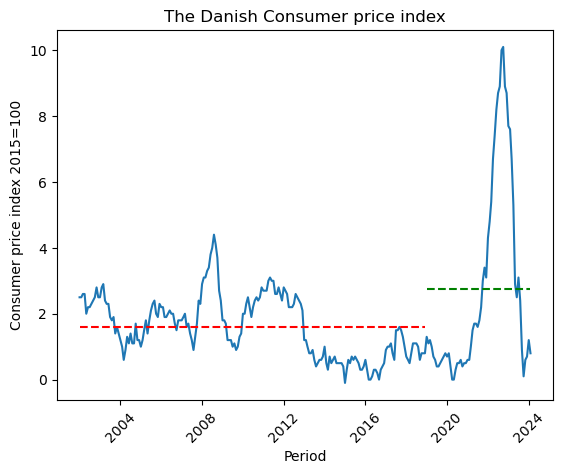

In [4]:
# Plotting the values of the column 00 Forbrugerprisindekset i alt (meaning priceindex in total)
Consumerpriceindex = df['00 Forbrugerprisindekset i alt']
plt.plot(df.index, Consumerpriceindex)

first_period = df[(df.index.year >= 2002) & (df.index.year <= 2018)]
second_period = df[(df.index.year >= 2019) & (df.index.year <= 2024)]


mean_first_period = first_period['00 Forbrugerprisindekset i alt'].mean()
mean_second_period = second_period['00 Forbrugerprisindekset i alt'].mean()

# Plot mean trend lines for each period
plt.hlines(mean_first_period, first_period.index.min(), first_period.index.max(), colors='r', linestyles='--', label=f'Mean 2002-2018: {mean_first_period:.2f}')
plt.hlines(mean_second_period, second_period.index.min(), second_period.index.max(), colors='g', linestyles='--', label=f'Mean 2018-2024: {mean_second_period:.2f}')
plt.title('The Danish Consumer price index') 
plt.xlabel('Period')
plt.ylabel('Consumer price index 2015=100')
plt.xticks(rotation=45)
plt.show()

Here we see that the inflation has been stable for most of the years apart from around the financial crisis and covid crisis, where we see spikes. We see that the average mean is a significantly higher with the covid crisis.

To take a further look we can plot some of the biggest and/or most volitile sectors. We choose "foods", "electricity, gas and others" and "Rent".

# Analysis - what drives inflation

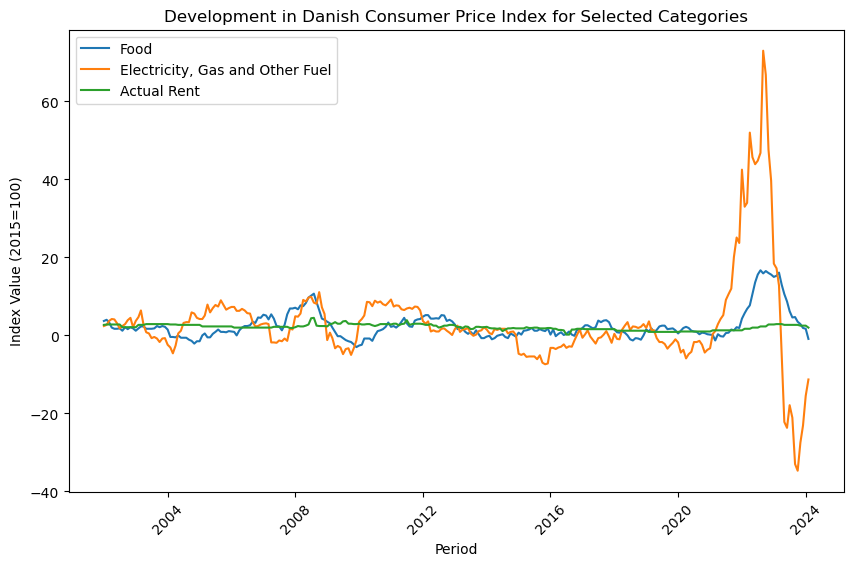

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['01.1 Fødevarer'], label='Food')
plt.plot(df.index, df['04.5 Elektricitet, gas og andet brændsel'], label='Electricity, Gas and Other Fuel')
plt.plot(df.index, df['04.1 Faktisk husleje'], label='Actual Rent')

# Adding plot title and labels
plt.title('Development in Danish Consumer Price Index for Selected Categories')
plt.xlabel('Period')
plt.ylabel('Index Value (2015=100)')

plt.legend()
plt.xticks(rotation=45)

plt.show()

Here we see that rent has been stable in the whole period. On the other side we see that electricity, gas and other has been very versatile, and is very consistent with the result for the overall inflation. 

# Further analysis - is there a comparison between real rate and inflation

Import real rate and cleaning

In [62]:
import pandas as pd

# Import real rate data
df = pd.read_excel("Rente data.xlsx")
print(df)

# Convert the 'DATE' column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

# Set the 'DATE' column as the index
df.set_index('DATE', inplace=True)

# Resample the data by month and calculate the average
monthly_df = df.resample('M').mean()

# Reset the index to convert the 'DATE' index back to a column
monthly_df.reset_index(inplace=True)

# Format the 'DATE' column to 'YYYYMM'
monthly_df['DATE'] = monthly_df['DATE'].dt.strftime('%Y\'%m').str.replace('\'', 'M')

# Display the cleaned dataframe
print(monthly_df)

# Saving the cleaned DataFrame
monthly_df.to_excel("cleaned_Realrate.xlsx")


            DATE  OBS.VALUE
0     2004-09-06   3.457222
1     2004-09-07   3.479518
2     2004-09-08   3.507894
3     2004-09-09   3.430628
4     2004-09-10   3.374729
...          ...        ...
7151  2024-04-05   2.348748
7152  2024-04-06        NaN
7153  2024-04-07        NaN
7154  2024-04-08   2.402902
7155  2024-04-09   2.364642

[7156 rows x 2 columns]
        DATE  OBS.VALUE
0    2004M09   3.372940
1    2004M10   3.220237
2    2004M11   3.121089
3    2004M12   2.977029
4    2005M01   2.967852
..       ...        ...
231  2023M12   2.070337
232  2024M01   2.102569
233  2024M02   2.308056
234  2024M03   2.355291
235  2024M04   2.365526

[236 rows x 2 columns]


Importing and cleaning data for merging.

Cleaning Data on inflation, and merging with real rate data.

In [65]:
import pandas as pd

# Import Inflation Data
df_inflation = pd.read_excel("cleaned_Inflation.xlsx")

# Renaming 'Periode' to 'DATE'
df_inflation.rename(columns={'Periode': 'DATE'}, inplace=True)

# Dropping all columns except '00 Forbrugerprisindekset i alt'
df_inflation = df_inflation[['DATE', '00 Forbrugerprisindekset i alt']]

# Converting 'DATE' to datetime format assuming the format is YYYYMM
df_inflation['DATE'] = pd.to_datetime(df_inflation['DATE'], format='%YM%m')

# Dropping rows before '2004-09-01'
df_inflation = df_inflation[df_inflation['DATE'] >= '2004-09-01']

# Import Real rate data
df_realrate = pd.read_excel("cleaned_Realrate.xlsx")

# Convert 'DATE' to datetime format assuming the format is YYYYMM
df_realrate['DATE'] = pd.to_datetime(df_realrate['DATE'], format='%YM%m')

# Merge the two dataframes on the 'DATE' column
merged_df = pd.merge(df_inflation, df_realrate, on='DATE')

# Rename the relevant columns to 'inflation' and 'real_rate'
merged_df.rename(columns={
    '00 Forbrugerprisindekset i alt': 'inflation',
    'OBS.VALUE': 'real_rate'
}, inplace=True)

print(merged_df)

# Optionally, save the merged data to a new Excel file
merged_df.to_excel('merged_data.xlsx', index=False)

          DATE  inflation  Unnamed: 0  real_rate
0   2004-09-01        1.1           0   3.372940
1   2004-10-01        1.7           1   3.220237
2   2004-11-01        1.2           2   3.121089
3   2004-12-01        1.2           3   2.977029
4   2005-01-01        1.0           4   2.967852
..         ...        ...         ...        ...
229 2023-10-01        0.1         229   2.776121
230 2023-11-01        0.6         230   2.560302
231 2023-12-01        0.7         231   2.070337
232 2024-01-01        1.2         232   2.102569
233 2024-02-01        0.8         233   2.308056

[234 rows x 4 columns]


Now plotting for the analysis.

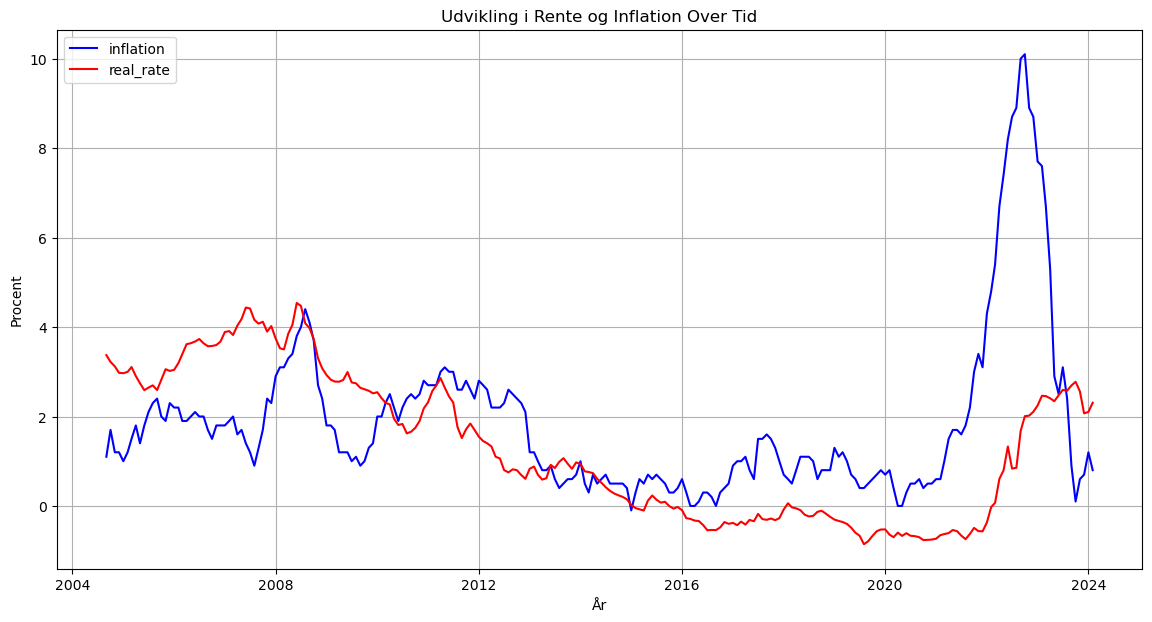

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Læs den merged Excel-fil
data = pd.read_excel('merged_data.xlsx')

# Plot rente og inflation over tid
plt.figure(figsize=(14, 7))
plt.plot(data['DATE'], data['inflation'], label='inflation', color='blue')
plt.plot(data['DATE'], data['real_rate'], label='real_rate', color='red')
plt.xlabel('År')
plt.ylabel('Procent')
plt.title('Udvikling i Rente og Inflation Over Tid')
plt.legend()
plt.grid(True)
plt.show()


# Conclusion

Conclusion will be written when all the code is done